## Install package from GitHub

In [3]:
# !pip3 install git+https://github.com/yicjia/CausalDeepCENT.git -q

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [1]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))


/var/folders/38/05rshw150dz6n2rqnqpvq49h0000gp/T/ipykernel_70280/1372205583.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# pip list
import sys
!{sys.executable} -m pip install lifelines

In [2]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()
import matplotlib.pyplot as plt


In [3]:
# imports for tutorial of wrapped POC model
from CausalDeepCENT import causal_deepcent as cdc
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
from torch.utils.data import DataLoader, TensorDataset
import lifelines

In [4]:
## check device (CPU or GPU)
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

In [5]:
device

device(type='cpu')

In [52]:
# imports for model backend code 


import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as dist

from sklearn.linear_model import LogisticRegression

import math
import csv
import os
import time

In [53]:
# model backend code wrapped 


class Net(nn.Module):
    def __init__(self, n_feature, num_layers, node, dropout, drop_factor = 1):
        super(Net, self).__init__()
        # input layer
        layers = [nn.Linear(n_feature, node),
                  nn.BatchNorm1d(node),
                  nn.ReLU()]
        # hidden layers
        node_temp = node
        for i in range(0, num_layers):
            node_temp0 = max(4, int(node_temp / (drop_factor**i)))
            node_temp1 = max(4, int(node_temp0 / drop_factor))
            layers += [nn.Linear(node_temp0, node_temp1),
                       nn.BatchNorm1d(node_temp1),
                       nn.ReLU(),
                       nn.Dropout(p=dropout)]
        layers += [nn.ReLU()]
        # output layer
        layers += [nn.Linear(node_temp1, 1)]
        self.seq = nn.Sequential(*layers) 

    def forward(self, inputs):
        return self.seq(inputs)  


def getIPW(y, x):
    model = LogisticRegression(solver='liblinear').fit(x, y)
    p = model.predict_proba(x)[:, 1]
    w = y/p+(1-y)/(1-p)
    return w


def weighted_mse_loss(pred, obs, delta, weight, lambda1):
    mse = delta*((pred - obs) ** 2)

    ind = pred < obs
    delta0 = 1 - delta
    p = ind * delta0 * (obs - pred)**2 
    return ((mse+lambda1*p)*weight).mean()

def enable_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def Causal_DeepCENT(train_dataset, test_dataset, num_feature, num_layers, node, dropout, lr, lambda1, num_epoch, batch_size, seed=123, T=100):
    torch.manual_seed(seed)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

    model = Net(n_feature=num_feature, num_layers = num_layers, node=node, dropout=dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-8)


    # Trianing
    epoch_loss_train = []
    for e in range(1, num_epoch+1):
        epoch_loss = 0

        model.train()
        for X_train_batch, y_train_batch, E_train_batch, W_train_batch in train_loader:
            optimizer.zero_grad()
        
            y_train_pred = model(X_train_batch)
            mseloss = weighted_mse_loss(y_train_pred, y_train_batch.unsqueeze(1), E_train_batch.unsqueeze(1), W_train_batch.unsqueeze(1),lambda1)
            train_loss = mseloss 
            train_loss.backward()
            optimizer.step()

   

    # Predicting test
    with torch.no_grad():
        #model.train()
        model.eval()
        enable_dropout(model)
        result = []
        for _ in range(T): 
            y_pred_list = [] 
            for X_batch, _, _ in test_loader:
                y_test_pred = model(X_batch)
                y_pred_list.append(y_test_pred.cpu().numpy())
                y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
                if len(y_pred_list)>1: y_pred_list = sum(y_pred_list, [])
            result.append(y_pred_list)
        
        result = np.array(result)
        y_test_pred_mean = result.mean(axis=0).reshape(-1,)
        y_test_pred_sd = result.std(axis=0).reshape(-1,)
        y_pred_list_upper = y_test_pred_mean + 1.96*y_test_pred_sd
        y_pred_list_lower = y_test_pred_mean - 1.96*y_test_pred_sd

    
    return y_test_pred_mean,y_pred_list_upper, y_pred_list_lower



## Load data

In [10]:
# df = pd.read_csv('https://raw.githubusercontent.com/yicjia/CausalDeepCENT/master/METABRIC_4genes.csv')
# df["W"] = cdc.getIPW(df["Chemotherapy"],df.drop(["time","event","Chemotherapy"], axis = 1))


## Split the data into training and test sets
# train_df, test_df = train_test_split(df, test_size=0.3,random_state=2)

In [55]:
# Load SPECTRUM Data 

df = pd.read_csv("spectrum_os.csv", sep="\t")
# format df to match existing column names / values 
df.rename(columns={"t2":"time", "s2":"event"}, inplace=True)
df.drop(["t1","s1"], axis=1, inplace=True)
df.replace({"event":1}, 0, inplace=True)  # not death
df.replace({"event":3}, 1, inplace=True)  # death 


# estimate propensity score via logistic regression
# in a RCT, we know the probability of treatment P(A), but lets allow it to be estimated ... 
df["W"] = cdc.getIPW(df["A"],df[["Z1","Z2","Z3","Z4"]])


In [54]:
## Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.3,random_state=2)
train_df

,id,time,event,Z1,Z2,Z3,Z4,A,W
165,221601003,235,1,-11.767308,0,0,1,-1,1.661378
134,221402008,207,1,-5.767308,0,1,0,1,1.878387
30,221110003,35,0,5.232692,1,1,0,-1,2.141481
204,222203003,15,1,6.232692,0,1,0,-1,1.804733
10,221101012,69,1,13.232692,0,1,0,-1,1.474000
...,...,...,...,...,...,...,...,...,...
75,221210005,13,1,1.232692,1,1,0,-1,2.342738
466,224023002,190,1,-5.767308,1,1,0,-1,2.709180
299,223609009,48,1,-3.767308,1,0,0,-1,2.273709
493,224404005,563,1,-5.767308,1,0,0,1,1.884844


In [14]:
# Prepare the data for Training + Testing 

# TRAIN 
X_train = train_df.drop(["time","event","W", "id"], axis = 1)

NUM_FEATURES = X_train.shape[1]

# save vars for post-prediction inference
y_train = np.log(train_df["time"])
E_train = train_df["event"]
W_train = train_df["W"]


# TEST 

# save vars for post-prediction inference
X_test = test_df.drop(["time","event","W", "id"], axis = 1)
y_test = np.log(test_df["time"])
E_test = test_df["event"]

# normalize variables  
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#
# Format data for CPU/GPU Processing (Tensor wrapper)
#

# TRAIN  
X_train, y_train, E_train, W_train = (
    np.array(X_train), 
    np.array(y_train), 
    np.array(E_train), 
    np.array(W_train)
)

train_dataset = TensorDataset(
    torch.from_numpy(X_train).float().to(device), 
    torch.from_numpy(y_train).float().to(device), 
    torch.from_numpy(E_train).float().to(device), 
    torch.from_numpy(W_train).float().to(device)
)

# TEST
X_test, y_test, E_test = (
    np.array(X_test), 
    np.array(y_test), 
    np.array(E_test)
)

test_dataset = TensorDataset(
    torch.from_numpy(X_test).float().to(device), 
    torch.from_numpy(y_test).float().to(device), 
    torch.from_numpy(E_test).float().to(device)
)

In [15]:
train_df.drop(["time","event","W", "id"], axis = 1)  #X_train

,Z1,Z2,Z3,Z4,A
165,-11.767308,0,0,1,-1
134,-5.767308,0,1,0,1
30,5.232692,1,1,0,-1
204,6.232692,0,1,0,-1
10,13.232692,0,1,0,-1
...,...,...,...,...,...
75,1.232692,1,1,0,-1
466,-5.767308,1,1,0,-1
299,-3.767308,1,0,0,-1
493,-5.767308,1,0,0,1


## Run CausalDeepCENT wrapped tutorial model

In [141]:
### Define hyperparameters
EPOCHS = 1000
BATCH_SIZE = 256
LEARNING_RATE = 1e-2
NODE = 128
NUM_LAYER = 1
LAMBDA1 = 0.01
DROPOUT = 0.2

In [142]:
y_test_pred, y_test_pred_upper, y_test_pred_lower = cdc.Causal_DeepCENT(
    train_dataset, 
    test_dataset, 
    NUM_FEATURES, 
    NUM_LAYER, 
    NODE, 
    DROPOUT, 
    LEARNING_RATE, 
    LAMBDA1, 
    EPOCHS, 
    BATCH_SIZE
)

In [161]:
# Output the prediction on test set
out_test = pd.DataFrame(
    list(
        zip(
            test_df["time"],
            np.exp(y_test_pred), 
            np.exp(y_test_pred_lower), 
            np.exp(y_test_pred_upper)
        )
    ),
    columns = ['time','pred_time','pred_time_lower','pred_time_upper']
)

# you can then save the dataframe out_test into your Google drive

In [25]:
out_test

out_test['pct_error'] = abs(out_test['time'] - out_test['pred_time'])/out_test['time']

In [26]:
out_test

,time,pred_time,pred_time_lower,pred_time_upper,pct_error
0,71,103.330776,62.352130,171.241129,0.455363
1,54,173.129481,104.578207,286.616286,2.206101
2,1197,101.621879,59.441298,173.734535,0.915103
3,20,115.536764,69.985956,190.734608,4.776838
4,209,129.372877,70.213886,238.376509,0.380991
...,...,...,...,...,...
151,14,170.550213,98.147891,296.362714,11.182158
152,77,251.138818,140.378672,449.289802,2.261543
153,179,162.739839,93.011713,284.741075,0.090839
154,309,141.353103,82.491356,242.215679,0.542547


[0, 1554]
[0, 386.8795533204593]


<Axes: xlabel='time', ylabel='pred_time'>

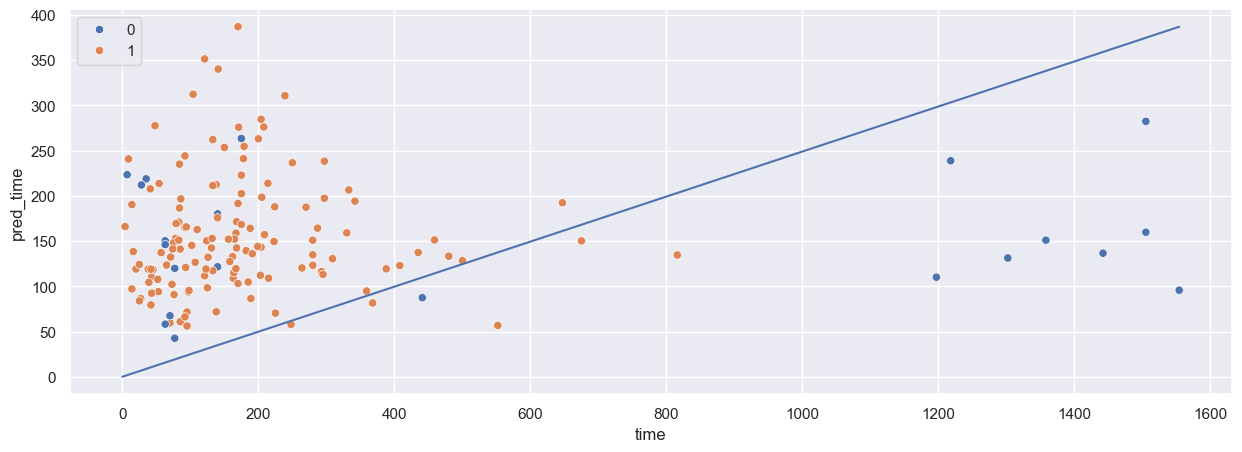

In [140]:
out_test['event'] = E_test
data = out_test

# initialize figure 
fig, ax = plt.subplots(figsize=(15, 5))

# Predicted vs Actual (color by Censored status)
sns.scatterplot(
    data, 
    x="time", 
    y="pred_time", 
    hue='event',
    ax = ax
)


diag_x = [0, max(data['time'].max(),data['time'].max())]
diag_y = [0, max(data['pred_time'].max(),data['pred_time'].max())]

print(diag_x)
print(diag_y)
sns.lineplot(x=diag_x,y=diag_y, ax=ax )
# 


# plot mean and uncertainty
plt.plot(data$time, data$pred_time, 'or')
plt.plot(x_test, m, 'gray')
plt.fill_between(x_test, y_test_pred_upper, y_test,
                 color='lightblue', alpha=0.5) # plot two std (95% confidence)


# How to One-Hot Encode The Patient Covariates ? 

## Get prediction on a new patient

In [ ]:
# ## If you have several new patients, please organize them into a dataframe that has the exact same column names as the trainig set in this tutorial,
# ## and replace the "test_df"

# ## If you only have one or two new entries, then input the covariates values below
# ## Here are two individuals with the same covariates value but one without and the other with chemotherapy
# Cov = {
#  "ER.Status": [0,0],
#  "HER2.Status": [0,0],
#  "PR.Status": [0,0],
#  "Tumor.Size": [25,25],
#  "Age.at.Diagnosis.x": [46,46],
#  "Lymph.nodes.examined.positive": [8,8],
#  "Nottingham.prognostic.index":[6,6],
#  "Chemotherapy": [0,1],
#  "Hormone.Therapy": [0,0],
#  "Inferred.Menopausal.State": [0,0],
#  "Radio.Therapy": [1,1],
#  "MKI67": [5.96, 5.96],
#  "EGFR": [6.19, 6.19],
#  "PGR": [11.92, 11.92],
#  "ERBB2": [5.27, 5.27]
# }

In [ ]:
# # using the whole dataset as training set
# X_train = df.drop(["time","event","W"], axis = 1)
# NUM_FEATURES = X_train.shape[1]
# y_train = np.log(df["time"])
# E_train = df["event"]
# W_train = df["W"]

# # new entires as test set
# X_test_new = pd.DataFrame(Cov)


# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test_new = scaler.transform(X_test_new)
# X_train, y_train, E_train, W_train = np.array(X_train), np.array(y_train), np.array(E_train), np.array(W_train)
# train_dataset = TensorDataset(torch.from_numpy(X_train).float().to(device), torch.from_numpy(y_train).float().to(device), torch.from_numpy(E_train).float().to(device), torch.from_numpy(W_train).float().to(device))
# test_dataset_new = TensorDataset(torch.from_numpy(np.array(X_test_new)).float().to(device), torch.empty(X_test_new.shape[0]), torch.empty(X_test_new.shape[0]))

In [ ]:
# y_test_pred, y_test_pred_upper, y_test_pred_lower = cdc.Causal_DeepCENT(train_dataset, test_dataset_new, NUM_FEATURES, NUM_LAYER, NODE, DROPOUT, LEARNING_RATE, LAMBDA1, EPOCHS, BATCH_SIZE)

In [ ]:
# # Output the prediction on test set
# out_test = pd.DataFrame(list(zip(np.exp(y_test_pred), np.exp(y_test_pred_lower), np.exp(y_test_pred_upper))),columns=['pred_time','pred_time_lower','pred_time_upper'])

# Tuning Model 

In [152]:
### Define hyperparameters


# Choosing epochs ... 
#  Early stopping vs Double Descent ?? 

EPOCHS = 10
BATCH_SIZE = 64
# Power of 2. As large as operates on cpu, but (i think) smaller than sample size.
# Do we care about CPU FOR 
# BATCH_NORMALISATION 
LEARNING_RATE = 1e-2
NODE = 128 
NUM_LAYER = 1
LAMBDA1 = 0.01
DROPOUT = 0.2


# def Causal_DeepCENT(
#     train_dataset, 
#     test_dataset, 
#     num_feature, 
#     num_layers, 
#     node, 
#     dropout, 
#     lr, 
#     lambda1, 
#     num_epoch, 
#     batch_size, 
#     seed=123, 
#     T=100
# ):

seed = 123
T=100
num_feature = NUM_FEATURES
num_layers = NUM_LAYER
node = NODE 
dropout = DROPOUT
lr = LEARNING_RATE
batch_size = BATCH_SIZE
num_epoch = EPOCHS
lambda1 = LAMBDA1


# to save to file 
hyperparameters = {
    "seed ": 123,
    "T":100,
    "num_feature ": NUM_FEATURES,
    "num_layers ": NUM_LAYER,
    "node ": NODE ,
    "dropout ": DROPOUT,
    "lr ": LEARNING_RATE,
    "batch_size ": BATCH_SIZE,
    "num_epoch ": EPOCHS,
    "lambda1 ": LAMBDA1
}


experiment_name = "spectrum_tuning_01"
with open(".json", "w") as out_file:
    json.dump(hyperparameters, out_file, indent=4)
    

Text(0, 0.5, 'MSE-Loss')

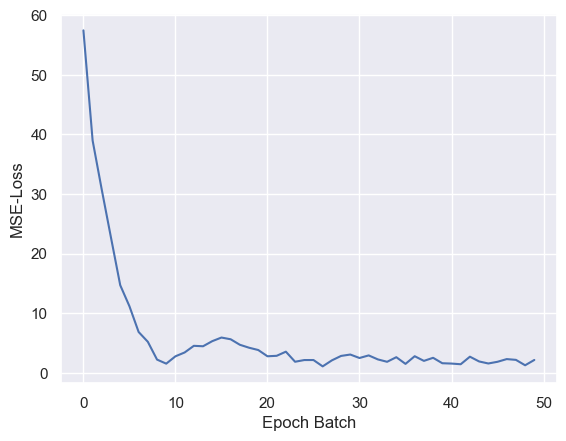

In [153]:
# TRAINING 

# initialize model 
torch.manual_seed(seed)

model = Net(
    n_feature=num_feature, 
    num_layers = num_layers, 
    node=node, 
    dropout=dropout
)

model.to(device)


# choose optimizer 
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-8)

# Trianing
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    drop_last=True
)


# 
epoch_loss_train = []

for e in range(1, num_epoch+1):
    epoch_loss = 0

    model.train()
    for X_train_batch, y_train_batch, E_train_batch, W_train_batch in train_loader:
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)
        mseloss = weighted_mse_loss(
            y_train_pred, 
            y_train_batch.unsqueeze(1), 
            E_train_batch.unsqueeze(1), 
            W_train_batch.unsqueeze(1),
            lambda1
        )
        
        # print(mseloss.detach().numpy())
        epoch_loss_train += [mseloss.detach().numpy()]
        
        train_loss = mseloss 
        train_loss.backward()
        optimizer.step()
        
        
#         if t % 5 == 0:
#             # plot and show learning process
#             plt.cla()
#             plt.scatter(x.data.numpy(), y.data.numpy())
#             plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
#             plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
#             plt.pause(0.1)



# print(epoch_loss_train)
plt.plot(epoch_loss_train)
plt.xlabel("Epoch Batch")
plt.ylabel("MSE-Loss")


In [154]:
# Testing 

test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=len(test_dataset)
)

# What is happening here ? 
with torch.no_grad():
    
    #model.train()
    model.eval()
    
    enable_dropout(model)
    
    result = []
    for _ in range(T): 
        y_pred_list = [] 
        for X_batch, _, _ in test_loader:
            y_test_pred = model(X_batch)
            y_pred_list.append(y_test_pred.cpu().numpy())
            y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
            if len(y_pred_list)>1: y_pred_list = sum(y_pred_list, [])
        result.append(y_pred_list)

    result = np.array(result)
    
    # mean, sd per datum ?? 
    y_test_pred_mean = result.mean(axis=0).reshape(-1,)
    y_test_pred_sd = result.std(axis=0).reshape(-1,)
    
    ## Question: Is the Normal Distribution appropriate ? 
    y_pred_list_upper = y_test_pred_mean + 1.96*y_test_pred_sd
    y_pred_list_lower = y_test_pred_mean - 1.96*y_test_pred_sd


# return y_test_pred_mean,y_pred_list_upper, y_pred_list_lower


In [155]:
# Output the prediction on test set
out_test = pd.DataFrame(
    list(
        zip(
            test_df["time"],
            np.exp(y_test_pred_mean), 
            np.exp(y_test_pred_lower), 
            np.exp(y_test_pred_upper))
    ),
    columns=['time','pred_time','pred_time_lower','pred_time_upper']
)

# you can then save the dataframe out_test into your Google drive

out_test['pct_error'] = abs(out_test['time'] - out_test['pred_time'])/out_test['time']
out_test['event'] = E_test # censor status 
data = out_test


In [158]:
# MSE 
test_mse = np.mean(np.absolute(out_test['time'] - out_test['pred_time']))
print("test_mse")
print(test_mse)

test_mse
160.73554574446527


[0, 1554]
[0, 308.3346642330207]


<Axes: xlabel='time', ylabel='pred_time'>

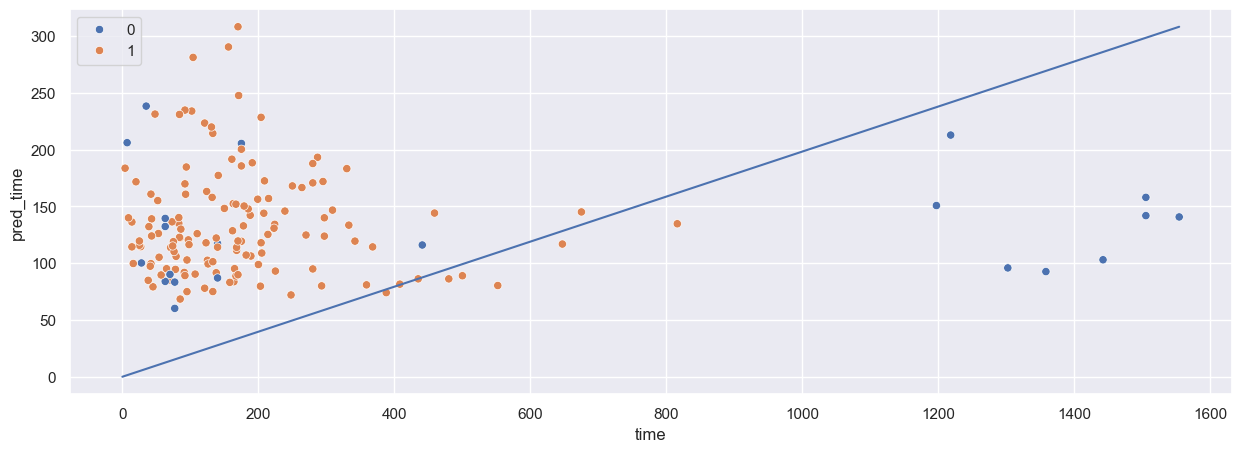

In [159]:
# initialize figure 
fig, ax = plt.subplots(figsize=(15, 5))

# Predicted vs Actual (color by Censored status)
sns.scatterplot(
    data, 
    x="time", 
    y="pred_time", 
    hue='event',
    ax = ax
)

diag_x = [0, max(data['time'].max(),data['time'].max())]
diag_y = [0, max(data['pred_time'].max(),data['pred_time'].max())]

print(diag_x)
print(diag_y)
sns.lineplot(x=diag_x,y=diag_y, ax=ax )




